# DELE CA2 Part B - RL

In [1]:
# Run in Google Colab
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools > /dev/null 2>&1
!pip install ez-setup > /dev/null 2>&1
!pip install gym wandb pyvirtualdisplay box2d box2d-py > /dev/null 2&>1

## Background Research

The LunarLander-v2 environment is not easily installed on Windows. Therefore we used Google Colab to run the experiments. We mounted Google Drive to save the required artifacts periodically, as well as the log files which contained the learning progress of the models.

The observation space of LunarLander-v2 consists of 8 elements. They are defined as follows:
<table style="font-size: small;">
    <tbody>
        <tr>
            <td>X-Coordinate (float)</td>
            <td>Y-Coordinate (float)</td>
            <td>X-Velocity (float)</td>
            <td>Y-Velocity (float)</td>
            <td>Angle (float)</td>
            <td>Angular Velocity (float)</td>
            <td>Left Leg Landed (bool)</td>
            <td>Right Leg Landed (bool)</td>
        </tr>
    </tbody>
</table>

The action space of LunarLander-v2 consists of 4 discrete actions. They are defined as follows:
<table>
    <tbody>
        <tr>
            <td>Do Nothing</td>
            <td>Fire Left Engine</td>
            <td>Fire Main (Bottom) Engine</td>
            <td>Fire Right Engine</td>
        </tr>
    </tbody>
</table>

Reward Scheme
* Reward for moving from the top of the screen to the landing pad with zero speed is about 100..140 points.
* If the lander moves away from the landing pad it loses reward.
* If the lander crashes, it receives an additional -100 points.
* If it comes to rest, it receives an additional +100 points.
* Each leg with ground contact is +10 points.
* Firing the main engine is -0.3 points each frame.
* Firing the side engine is -0.03 points each frame.
* Solved is 200 points.

Starting State
* The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

Episode Termination Conditions
1. the lander crashes (the lander body gets in contact with the moon);
2. the lander gets outside of the viewport (`x` coordinate is greater than 1);
3. the lander is not awake.

> From the [Box2D docs](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61), a body which is not awake is a body which doesn't move and doesn't collide with any other body

Candidate RL Algorithms
* Simple DQN
* Double DQN
* Dueling DQN
* PPO
* REINFORCE
* ...

The algorithms used were simple DQN and Double DQN.

Surprisingly, simple DQN outperformed Double DQN.

## Import Dependencies

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
import tensorflow as tf

# Graphing Dependencies
from matplotlib import pyplot as plt
import seaborn as sb

# Neural Networks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.regularizers import *

# Reinforcement Learning
import gym

# Model Tracking
import wandb

# Data Structures
from collections import deque

# Display Media
from IPython.display import Video
from pyvirtualdisplay import Display

# Miscellaneous
import os
import pickle

## EDA

### Create Environment

<table>
    <tbody>
        <tr>
            <th scope="row" style="text-align: left;">Environment</th>
            <td>LunarLander</td>
        </tr>
        <tr>
            <th scope="row" style="text-align: left;">Version</th>
            <td>2</td>
        </tr>
    </tbody>
</table>

In [ ]:
ENV = gym.make('LunarLander-v2')

### Environment Variables

In [ ]:
# 8 values representing each possible state
ENV.observation_space.shape

(8,)

In [ ]:
# 4 discrete actions
ENV.action_space

Discrete(4)

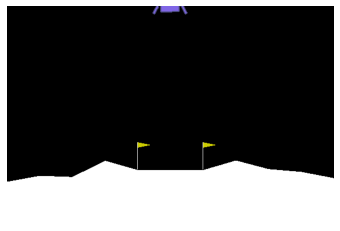

In [ ]:
# Preview how the environment looks like
def display_start_screen(env):
    display = Display(visible=False)
    display.start()
    env.reset()
    snapshot = env.render(mode='rgb_array')
    plt.imshow(snapshot)
    plt.axis('off')

display_start_screen(ENV)

### Baseline - Random Policy Agent

In [ ]:
#!xvfb-run -a -s "-screen 0 640x480x24" python make_video_random.py

In [2]:
# Video generated using make_video_random.py
Video('./video/LunarLander-v2-Random.mp4')

In [ ]:
def random_agent_scores(env, episodes=100):
    scores = []
    for episode in range(episodes):
        env.reset()
        done = False
        returns = 0
        while not done:
            action = env.action_space.sample()
            _, reward, done, _ = env.step(action)
            returns += reward
        scores.append(returns)
        if episode < 10:
            print(f'Episode {episode + 1} Returns: {returns}')
    plt.plot(scores)
    plt.title('Scores of Random Policy Agent over 100 Episodes')

Episode 1 Returns: -103.30978122836316
Episode 2 Returns: -220.9447548656821
Episode 3 Returns: -75.79906987276433
Episode 4 Returns: -272.33746159828013
Episode 5 Returns: -317.04431995711474
Episode 6 Returns: -155.73558361381237
Episode 7 Returns: -114.49178483659843
Episode 8 Returns: -160.03647882487172
Episode 9 Returns: -225.79553423912128
Episode 10 Returns: -85.62504139801258


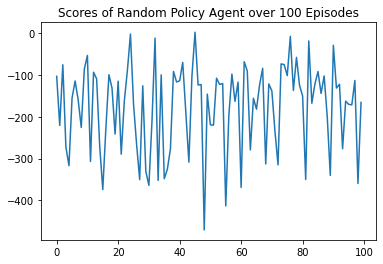

In [ ]:
random_agent_scores(env=ENV)

## General Utilities

In [ ]:
# wandb.login()

In [ ]:
ARTIFACT_STORE = 'drive/MyDrive/rl/'

In [3]:
sb.set_style('darkgrid')

In [6]:
class ReplayBuffer:
    def __init__(self, max_length: int):
        self.max_length = max_length
        self.buffer = [None] * self.max_length
        self.pointer = 0
        self.size = 0

    def append(self, memory):
        if self.pointer >= self.max_length:
            self.pointer = 0
        elif self.size < self.max_length:
            self.size += 1
        self.buffer[self.pointer] = memory
        self.pointer += 1

    def sample(self, batch_size: int):
        return [self.buffer[i] for i in np.random.randint(0, self.size, batch_size)]
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def __len__(self):
        return self.size

In [7]:
class RewardTracker(deque):
    def __init__(self, max_length: int):
        super().__init__(maxlen=max_length)
        self.max_length = max_length

    def log(self, total_episodic_rewards):
        self.append(total_episodic_rewards)
    
    def get_rolling_mean(self):
        base = min(self.__len__(), self.max_length)
        return sum((r for r in self)) / float(base)

In [8]:
class FileLogger:
    def __init__(self, log_file: str, *args, sep: str=';'):
        self.log_file = log_file
        self.sep = sep
        self.n_args = len(args)
        if not os.path.exists(log_file):
            self.setup(args)
    
    def setup(self, args):
        header = self.sep.join(args)
        with open(self.log_file, mode='w') as f:
            f.write(header)
            f.write('\n')

    def log(self, **kwargs):
        assert len(kwargs) == self.n_args
        header = ''
        with open(self.log_file, mode='r') as f:
            header = f.readlines()[0].replace('\n', '')
        params = header.split(self.sep)
        values = (str(kwargs[p.lower()]) for p in params)
        entry = self.sep.join(values)
        with open(self.log_file, mode='a+') as f:
            f.write(entry)
            f.write('\n')
        return self
    
    def get_logs(self):
        df = pd.read_csv(self.log_file, header=0, sep=self.sep)
        past_rewards = df['Total_Rewards']
        return past_rewards

In [ ]:
# Courtesy of https://wingedsheep.com/lunar-lander-dqn/
def masked_huber_loss(mask_value, clip_delta):
    def f(y_true, y_pred):
        error = y_true - y_pred
        cond  = tf.abs(error) < clip_delta
        mask_true = tf.cast(tf.not_equal(y_true, mask_value), tf.float32)
        masked_squared_error = 0.5 * tf.square(mask_true * (y_true - y_pred))
        linear_loss  = mask_true * (clip_delta * tf.abs(error) - 0.5 * (clip_delta ** 2))
        huber_loss = tf.where(cond, masked_squared_error, linear_loss)
        return tf.reduce_sum(huber_loss) / tf.reduce_sum(mask_true)
    f.__name__ = 'masked_huber_loss'
    return f

In [4]:
def plot_learning_curve(log_file):
    df = pd.read_csv(log_file, sep=';', header=0)
    episodes = df['Episode']
    steps = df['Steps']
    rewards = df['Total_Rewards']
    reward_tracker = RewardTracker(max_length=100)
    rolling_score = []
    for r in rewards:
        reward_tracker.append(r)
        rolling_score.append(reward_tracker.get_rolling_mean())

    sb.set_style('darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].plot(episodes, steps)
    ax[0].set_title('Steps')
    ax[1].plot(episodes, rewards, label='Reward')
    ax[1].plot(episodes, rolling_score, label='100-Episode Rolling Mean')
    ax[1].set_title('Score')
    ax[1].legend()
    return f'Highest Mean Score: {max(rolling_score)}'

## Double DQN

In [ ]:
DDQN_ARTIFACT_STORE = ARTIFACT_STORE + 'ddqn/'

In [ ]:
DDQN_CONFIG = {
    'batch_size': 128,
    'alpha': 0.001,
    'epsilon': 1.0,
    'min_epsilon': 0.01,
    'epsilon_decay': 0.995,
    'gamma': 0.95,
    'tau': 0.2,
}

In [ ]:
wandb.init(project="lunarlander-ddqn",
           entity="user",
           config=DDQN_CONFIG)

In [ ]:
DDQN_CONFIG_STR = '_'.join((f'{k}={v}' for k, v in DDQN_CONFIG.items())) + '.log'
DDQN_CONFIG_STR

In [ ]:
def DDQN(input_shape, output_shape, alpha, regularization: float = 0.001):
    model = Sequential(layers=[
        Dense(256, input_shape=input_shape, activation='relu', kernel_regularizer=l2(regularization)),
        Dense(256, activation='relu', kernel_regularizer=l2(regularization)),
        Dense(output_shape, kernel_regularizer=l2(regularization))
    ])
    model.compile(loss=masked_huber_loss(0.0, 1.0), optimizer=Adam(learning_rate=alpha))
    return model

In [ ]:
class DDQN_Agent:
    def __init__(self,
                 env,
                 batch_size: int,
                 alpha: float,
                 epsilon: float,
                 min_epsilon: float,
                 epsilon_decay: float,
                 gamma: float,
                 tau: float,
                 regularization: float,
                 max_memory_length: int = 250_000,
                 checkpoint_interval: int = 10,
                 log_file: str = 'progress.log'):
        self.env = env
        self.batch_size = batch_size
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer(max_length = max_memory_length)
        self.model = DDQN(input_shape=env.observation_space.shape,
                         output_shape=env.action_space.n,
                         alpha=alpha,
                         regularization=regularization)
        self.target_model = DDQN(input_shape=env.observation_space.shape,
                         output_shape=env.action_space.n,
                         alpha=alpha,
                         regularization=regularization)
        self.file_logger = FileLogger(DDQN_ARTIFACT_STORE + log_file, 'Episode', 'Steps', 'Total_Rewards')
        self.checkpoint_interval = checkpoint_interval
    
    def checkpoint(self, episode, steps, total_rewards):
        self.file_logger.log(episode=episode, steps=steps, total_rewards=total_rewards)
        if episode % self.checkpoint_interval == 0:
            self.model.save(DDQN_ARTIFACT_STORE + f'{episode}.h5')
            with open(f'{DDQN_ARTIFACT_STORE}replay_buffer-{episode}.p', 'wb') as saved_buffer:
                pickle.dump(self.replay_buffer, saved_buffer)
    
    def act(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state.reshape(1, -1))[0])
    
    def calculate_target_values(self, memory_batch):
        states = []
        next_states = []
        for sample in memory_batch:
            states.append(sample[0])
            next_states.append(sample[3])
        states = np.array(states)
        next_states = np.array(next_states)

        q_values_next_state = self.model.predict(next_states)
        target_q_values_next_state = self.target_model.predict(next_states)

        targets = []
        for index, (s, a, r, s_, d) in enumerate(memory_batch):
            best_action = np.argmax(q_values_next_state[index])
            max_q_value_for_next_state = target_q_values_next_state[index, best_action]
            
            target_vector = [0, 0, 0, 0]
            target_vector[a] = r if d else r + self.gamma * max_q_value_for_next_state
            targets.append(target_vector)

        return states, np.array(targets)

    def learn(self):
        if len(self.replay_buffer) >= self.batch_size:
            samples = self.replay_buffer.sample(batch_size=self.batch_size)
            states, targets = self.calculate_target_values(samples)
            self.model.fit(states, targets, epochs=1, batch_size=targets.shape[0], verbose=0)
    
    def transfer_weights(self):
        policy_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        if self.tau > 0.0:
            for i, weights in enumerate(policy_weights):
                target_weights[i] = weights * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)
    
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [ ]:
def train_ddqn_agent(warm_start: int = 0):
    episodes = 1000
    max_steps_per_episode = 1000
    target_model_train_interval = 1
    reward_progress = RewardTracker(max_length=100)
    dqn_agent = DDQN_Agent(env=ENV, **DDQN_CONFIG, log_file=DDQN_CONFIG_STR)
    if warm_start >= 1:
        print(f'Resuming from last episode: {warm_start}')
        dqn_agent.epsilon = max(dqn_agent.min_epsilon, dqn_agent.epsilon_decay ** warm_start)
        dqn_agent.target_model = load_model(f'{DDQN_ARTIFACT_STORE}{warm_start}.h5',
                                            custom_objects={'masked_huber_loss': masked_huber_loss(0.0, 1.0)})
        dqn_agent.model = load_model(f'{DDQN_ARTIFACT_STORE}{warm_start}.h5',
                                            custom_objects={'masked_huber_loss': masked_huber_loss(0.0, 1.0)})
        with open(f'{DDQN_ARTIFACT_STORE}replay_buffer-{warm_start}.p', 'rb') as saved_buffer:
            dqn_agent.replay_buffer = pickle.load(saved_buffer)
        for r in dqn_agent.file_logger.get_logs():
            reward_progress.append(r)
    for episode in range(warm_start + 1, episodes + warm_start + 1):
        cur_state = ENV.reset()
        total_episode_rewards = 0
        for step in range(max_steps_per_episode):
            action = dqn_agent.act(cur_state)
            new_state, reward, done, _ = ENV.step(action)

            total_episode_rewards += reward
            print(f'\rEpisode: {episode}; Step: {step}; Reward: {reward}; Total Episode Rewards (thus far): {total_episode_rewards}', end='')

            dqn_agent.remember(cur_state, action, reward, new_state, done)
            dqn_agent.learn()
            cur_state = new_state
            if done or total_episode_rewards < -300:
                break
        else:
            print(f'\nFailed to complete episode {episode} within {max_steps_per_episode} steps')
        print()
        if episode % target_model_train_interval == 0:
            dqn_agent.transfer_weights()
        reward_progress.append(total_episode_rewards)
        print(f'Rolling Mean: {reward_progress.get_rolling_mean()}')
        dqn_agent.checkpoint(episode=episode, steps=step, total_rewards=total_episode_rewards)
        dqn_agent.decay_epsilon()
        if total_episode_rewards < 200:
            print("Episode failed")
        else:
            print(f"Completed in {episode} episodes")
        print(f'New Epsilon: {dqn_agent.epsilon}')
        wandb.log({
            'episode': episode,
            'steps': step,
            'total rewards': total_episode_rewards
        })

In [ ]:
train_ddqn_agent(warm_start=0)

In [ ]:
wandb.finish()

'Highest Mean Score: 12.040807599441289'

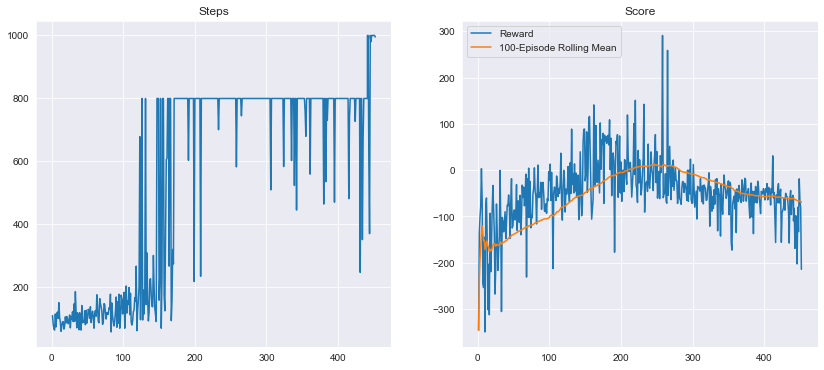

In [9]:
plot_learning_curve('./logs/ddqn.log')

## Vanilla DQN

In [ ]:
DQN_ARTIFACT_STORE = ARTIFACT_STORE + 'dqn/'

In [ ]:
DQN_CONFIG = {
    'batch_size': 64,
    'alpha': 0.0005,
    'epsilon': 1.0,
    'min_epsilon': 0.01,
    'epsilon_decay': 0.995,
    'gamma': 0.99
}

In [ ]:
DQN_CONFIG_STR = '_'.join((f'{k}={v}' for k, v in DQN_CONFIG.items())) + '.log'
DQN_CONFIG_STR

In [ ]:
wandb.init(project="lunarlander-dqn",
           entity="user",
           config=DQN_CONFIG)

In [ ]:
def DQN(input_shape, output_shape, alpha):
    model = Sequential(layers=[
        Dense(256, input_shape=input_shape, activation='relu'),
        Dense(256, activation='relu'),
        Dense(output_shape)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=alpha))
    return model

In [ ]:
class DQN_Agent:
    def __init__(self,
                 env,
                 batch_size: int,
                 alpha: float,
                 epsilon: float,
                 min_epsilon: float,
                 epsilon_decay: float,
                 gamma: float,
                 max_memory_length: int = 300_000,
                 checkpoint_interval: int = 10,
                 log_file: str = 'progress.log'):
        self.env = env
        self.batch_size = batch_size
        self.alpha = alpha
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.replay_buffer = ReplayBuffer(max_length = max_memory_length)
        self.model = DQN(input_shape=env.observation_space.shape,
                         output_shape=env.action_space.n,
                         alpha=alpha)
        self.file_logger = FileLogger(DQN_ARTIFACT_STORE + log_file, 'Episode', 'Steps', 'Total_Rewards')
        self.checkpoint_interval = checkpoint_interval
    
    def checkpoint(self, episode, steps, total_rewards):
        self.file_logger.log(episode=episode, steps=steps, total_rewards=total_rewards)
        if episode % self.checkpoint_interval == 0:
            self.model.save(DQN_ARTIFACT_STORE + f'{episode}.h5')
            with open(f'{DQN_ARTIFACT_STORE}replay_buffer-{episode}.p', 'wb') as saved_buffer:
                pickle.dump(self.replay_buffer, saved_buffer)
    
    def act(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state.reshape(1, -1))[0])
    
    def calculate_target_values(self, memory_batch):
        states = []
        next_states = []
        for sample in memory_batch:
            states.append(sample[0])
            next_states.append(sample[3])
        states = np.array(states)
        next_states = np.array(next_states)

        q_values = self.model.predict(states)
        target_q_values = q_values.copy()
        
        q_values_next_state = self.model.predict(next_states)

        for index, (s, a, r, s_, d) in enumerate(memory_batch):
            max_q_value_for_next_state = np.max(q_values_next_state[index])
            target_q_values[index, a] = r if d else r + self.gamma * max_q_value_for_next_state

        return states, target_q_values

    def learn(self):
        if len(self.replay_buffer) >= self.batch_size:
            samples = self.replay_buffer.sample(batch_size=self.batch_size)
            states, targets = self.calculate_target_values(samples)
            self.model.fit(states, targets, epochs=1, batch_size=targets.shape[0], verbose=0)
            self.decay_epsilon()
    
    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [ ]:
def train_dqn_agent(warm_start: int = 0):
    episodes = 1000
    reward_progress = RewardTracker(max_length=100)
    dqn_agent = DQN_Agent(env=ENV, **DQN_CONFIG, log_file=DQN_CONFIG_STR)
    if warm_start >= 1:
        print(f'Resuming from last episode: {warm_start}')
        dqn_agent.epsilon = dqn_agent.min_epsilon
        dqn_agent.model = load_model(f'{DQN_ARTIFACT_STORE}{warm_start}.h5')
        with open(f'{DQN_ARTIFACT_STORE}replay_buffer-{warm_start}.p', 'rb') as saved_buffer:
            dqn_agent.replay_buffer = pickle.load(saved_buffer)
        for r in dqn_agent.file_logger.get_logs():
            reward_progress.append(r)
    for episode in range(warm_start + 1, episodes + warm_start + 1):
        cur_state = ENV.reset()
        total_episode_rewards = 0
        done = False
        step = 0
        while not done:
            action = dqn_agent.act(cur_state)
            new_state, reward, done, _ = ENV.step(action)

            total_episode_rewards += reward
            print(f'\rEpisode: {episode}; Step: {step}; Reward: {reward}; Total Episode Rewards (thus far): {total_episode_rewards}', end='')

            dqn_agent.remember(cur_state, action, reward, new_state, done)
            dqn_agent.learn()
            cur_state = new_state
            if done or total_episode_rewards < -300:
                break
            step += 1

        print()
        reward_progress.append(total_episode_rewards)
        print(f'Rolling Mean: {reward_progress.get_rolling_mean()}')
        dqn_agent.checkpoint(episode=episode, steps=step, total_rewards=total_episode_rewards)
        # dqn_agent.decay_epsilon()
        if total_episode_rewards < 200:
            print("Episode failed")
        else:
            print(f"Completed in {episode} episodes")
        print(f'New Epsilon: {dqn_agent.epsilon}')
        wandb.log({
            'episode': episode,
            'steps': step,
            'total rewards': total_episode_rewards
        })

In [ ]:
wandb.finish()

'Highest Mean Score: 233.8828892809272'

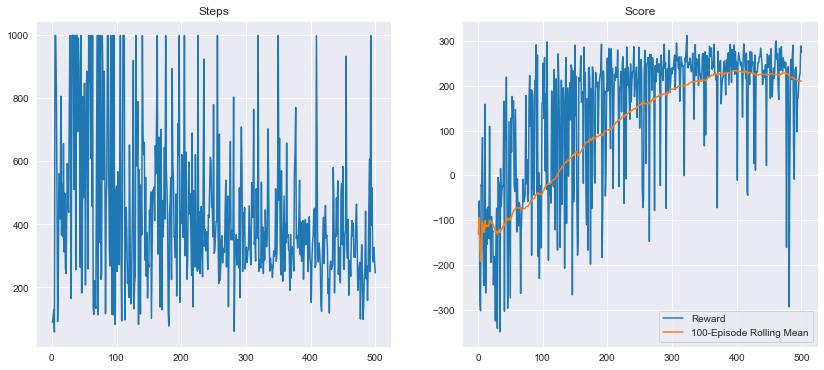

In [10]:
plot_learning_curve('./logs/dqn.log')

## Visualise Model Performance

In [ ]:
#!xvfb-run -a -s "-screen 0 640x480x24" python make_video_model.py

In [11]:
# During early stages of training
Video('./video/LunarLander-v2-50.mp4')

In [12]:
# Midway into training
Video('./video/LunarLander-v2-100.mp4')

In [14]:
# Towards the end of training
Video('./video/LunarLander-v2-350.mp4')

In [13]:
# Towards the end of training
Video('./video/LunarLander-v2-360.mp4')

## Conclusions

* A complex solution is not always the most optimal.
* Often, a simpler method is more elegant and yields better results
* One just has to have the patience to seek it out
* This assignment on reinforcement learning really made us rethink how humans ourselves learn

## References

* https://wingedsheep.com/lunar-lander-dqn/
* https://goodboychan.github.io/python/reinforcement_learning/pytorch/udacity/2021/05/07/DQN-LunarLander.html
* https://www.youtube.com/watch?v=UCgsv6tMReY